# Cardiac Arrhythmia Multy-Class Classification 

# Effort Table
<br>Syed Omer Wajihuddin 100%
<br>Mayank Jindal 100%

# Data Loading and Cleaning

In [8]:
import pandas as pd
import numpy as np
%matplotlib inline 

data = pd.read_csv('cardiac_arrhythmia.csv')
data = data.replace('?',np.NaN)

X = data.iloc[:,:-1]
Y = data.iloc[:,-1]

#Classes 11,12 and 13 have 0 instances so for simplicity sake we make classes 14,15,16 as 11,12 and 13 resp
for i in range(0,452):
    if (Y[i]>=14):
         Y[i]=Y[i]-3

## We are aggregating classes which have very few instances in 13th class
for i in range(0,452):
    if (Y[i]== 7 or Y[i] == 8):
        Y[i] = 13

############# To describe the data and check for missing values ####################

X.describe().transpose()

X.columns[X.isnull().any()].tolist() 

#Deleting the 14th column as it comprises mostly of null values
del X['x14']


E:\Anaconda\lib\site-packages\ipykernel\__main__.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
E:\Anaconda\lib\site-packages\ipykernel\__main__.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


# Imputation for missing values

In [9]:
#Few of the columns have few missing values hence we need to impute them

from fancyimpute import KNN
X_filled_KNN = KNN(k=5).complete(X)
X_filled_KNN = pd.DataFrame(X_filled_KNN)
X_filled_KNN.describe().transpose()

X_filled_KNN.describe().transpose()

#To check if the final data is devoid of null values
X_filled_KNN.columns[X_filled_KNN.isnull().any()].tolist()


Using TensorFlow backend.


Imputing row 1/452 with 0 missing, elapsed time: 0.261
Imputing row 101/452 with 0 missing, elapsed time: 0.262
Imputing row 201/452 with 1 missing, elapsed time: 0.262
Imputing row 301/452 with 1 missing, elapsed time: 0.263
Imputing row 401/452 with 0 missing, elapsed time: 0.264


[]

NameError: name 'pd' is not defined

# PCA Feature Selection

In [1]:
# We are trying to find the number of principal components which will explain atleast 95% of the variance in 
# the X varaibles s

from sklearn.decomposition import PCA

pca = PCA()
pca.fit(X_filled_KNN)
cumsum = np.cumsum(pca.explained_variance_ratio_)
d = np.argmax(cumsum >= 0.98) + 1

pca = PCA(n_components=0.98)
X_filled_KNN_pca = pca.fit_transform(X_filled_KNN)

print("Number of PCA components : {}".format(pca.n_components_))
print("Explained Variance : {:.2f}".format(np.sum(pca.explained_variance_ratio_)))


NameError: name 'X_filled_KNN' is not defined

# Train Test Split and Feature Scaling

In [11]:
from sklearn.model_selection import train_test_split
X_train,X_test,Y_train,Y_test = train_test_split(X_filled_KNN,Y,test_size = 0.2,random_state = 1)
X_train_pca,X_test_pca = train_test_split(X_filled_KNN_pca,test_size = 0.2,random_state = 1)


#################################### Feature Scaling ###########################################

#When all the variables are not in the same scale, it is often the case that the model doesnt 
#learn well from these features.
#Hence we need to ensure that all the variables are in the same scale. 
#In our case we use the min_max_scaling method

from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test) 
X_train_pca = sc.fit_transform(X_train_pca)
X_test_pca = sc.transform(X_test_pca) 


# KNN Classifier with All methods

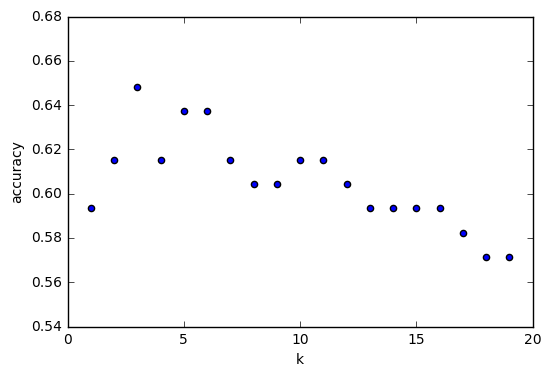

Cross Validation Score 0.6154
Accuracy of Training: 0.60
Recall: 0.60440
Accuracy: 0.60
             precision    recall  f1-score   support

          1       0.59      1.00      0.74        52
          2       1.00      0.12      0.22         8
          3       1.00      0.25      0.40         4
          4       1.00      1.00      1.00         1
          5       0.00      0.00      0.00         2
          6       0.00      0.00      0.00         3
          9       0.00      0.00      0.00         2
         10       0.00      0.00      0.00        10
         11       0.00      0.00      0.00         2
         13       0.00      0.00      0.00         7

avg / total       0.48      0.60      0.47        91



E:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


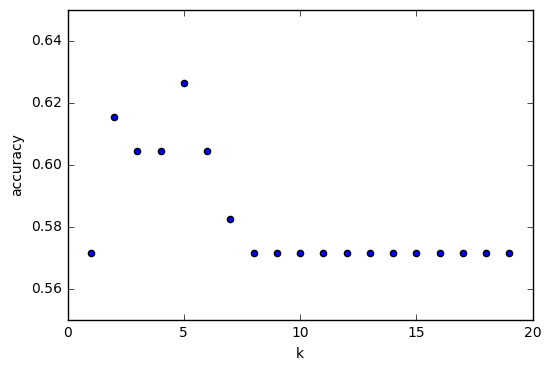

Cross Validation Score 0.6084


In [12]:
##### Without pca

from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt
k_range = range(1,20)
scores = []

for k in k_range:
    knn = KNeighborsClassifier(n_neighbors = k)
    knn.fit(X_train, Y_train)
    scores.append(knn.score(X_test, Y_test))

plt.figure()
plt.xlabel('k')
plt.ylabel('accuracy')
plt.scatter(k_range, scores)
plt.xticks([0,5,10,15,20]);
plt.show()


from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors = 3)
knn.fit(X_train,Y_train)
knn.score(X_test, Y_test)


from sklearn.model_selection import cross_val_score
from  sklearn.model_selection import StratifiedKFold
scores_knn = cross_val_score(knn,X_filled_KNN,Y,cv=StratifiedKFold(4,shuffle = True,random_state = 1))

print('Cross Validation Score {:.4f}'.format(np.mean(scores_knn)))



###### Bagging Method

from sklearn.ensemble import BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier

bag_clf_knn = BaggingClassifier(
    KNeighborsClassifier(n_neighbors = 3),
    bootstrap=True, n_jobs=-1, n_estimators=500, max_samples=100, random_state=1)

bag_clf_knn.fit(X_train, Y_train)

print('Accuracy of Training: {:.2f}'.format(bag_clf_knn.score(X_train, Y_train)))

from sklearn.metrics import recall_score, accuracy_score

y_predict_dt_bag = bag_clf_knn.predict(X_test)
print('Recall: {:.5f}'.format(recall_score(Y_test, y_predict_dt_bag, average="weighted")))
print('Accuracy: {:.2f}'.format(accuracy_score(Y_test, y_predict_dt_bag)))

from sklearn.metrics import classification_report

print(classification_report(Y_test, y_predict_dt_bag))




##### With PCA

from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt
k_range = range(1,20)
scores = []

for k in k_range:
    knn = KNeighborsClassifier(n_neighbors = k)
    knn.fit(X_train_pca, Y_train)
    scores.append(knn.score(X_test_pca, Y_test))

plt.figure()
plt.xlabel('k')
plt.ylabel('accuracy')
plt.scatter(k_range, scores)
plt.xticks([0,5,10,15,20]);
plt.show()


from sklearn.neighbors import KNeighborsClassifier
knn_pca = KNeighborsClassifier(n_neighbors = 5)
knn_pca.fit(X_train_pca,Y_train)
knn_pca.score(X_test_pca, Y_test)


from sklearn.model_selection import cross_val_score
from  sklearn.model_selection import StratifiedKFold
scores_knn_pca = cross_val_score(knn_pca,X_filled_KNN_pca,Y,cv=StratifiedKFold(4,shuffle = True,random_state = 1))

print('Cross Validation Score {:.4f}'.format(np.mean(scores_knn_pca)))


# Decision Tree Classifier

In [15]:
##### Without pca

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
dt_clf = DecisionTreeClassifier()
param_grid_dt = {'max_depth': [5, 10, 20, 50, 100]}
grid_search_dt = GridSearchCV(dt_clf,param_grid_dt,cv=StratifiedKFold(4,shuffle = True,random_state = 1))
grid_search_dt.fit(X_train, Y_train)   

dt_preds = grid_search_dt.predict(X_test)          

print('Best parameters{}\n'.format(grid_search_dt.best_params_))
print('Best score {:.2f}\n'.format(grid_search_dt.best_score_))


from sklearn.model_selection import cross_val_score
scores_dt_train = cross_val_score(grid_search_dt,X_train,Y_train,cv=StratifiedKFold(4,shuffle = True,random_state = 1))
scores_dt_test = cross_val_score(grid_search_dt,X_test,Y_test,cv=StratifiedKFold(4,shuffle = True,random_state = 1))
print('Train Cross Validation Score {:.2f}\n'.format(np.mean(scores_dt_train)))
print('Test Cross Validation Score {:.2f}\n'.format(np.mean(scores_dt_test)))


##### Gradient Boosted Decision Tree

from sklearn.ensemble import GradientBoostingClassifier
gb_dt = GradientBoostingClassifier(learning_rate = 0.01, max_depth = 2, random_state = 1)
gb_dt.fit(X_train, Y_train)

print('Cancer dataset (learning_rate=0.01, max_depth=2)')
print('Accuracy of GBDT classifier on training set: {:.2f}'
     .format(gb_dt.score(X_train, Y_train)))
print('Accuracy of GBDT classifier on test set: {:.2f}'
     .format(gb_dt.score(X_test, Y_test)))


###### Bagging Method

from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

bag_clf_dt = BaggingClassifier(
    DecisionTreeClassifier(max_depth = 7),
    bootstrap=True, n_jobs=-1, n_estimators=500, max_samples=100, random_state=1)

bag_clf_dt.fit(X_train, Y_train)

print('Accuracy of Training: {:.2f}'.format(bag_clf_dt.score(X_train, Y_train)))

from sklearn.metrics import recall_score, accuracy_score

y_predict_dt_bag = bag_clf_dt.predict(X_test)
print('Recall: {:.5f}'.format(recall_score(Y_test, y_predict_dt_bag, average="weighted")))
print('Accuracy: {:.2f}'.format(accuracy_score(Y_test, y_predict_dt_bag)))

from sklearn.metrics import classification_report

print(classification_report(Y_test, y_predict_dt_bag))


##### With AdaBoost

from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
ada_clf_dt = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth = 5),
    n_estimators=200,
    algorithm="SAMME.R", learning_rate=0.5, random_state=1)
ada_clf_dt.fit(X_train, Y_train)

print('Accuracy of Training: {:.2f}'.format(ada_clf_dt.score(X_train, Y_train)))

from sklearn.metrics import recall_score, accuracy_score

y_predict_dt = ada_clf_dt.predict(X_test)
print('Recall: {:.5f}'.format(recall_score(Y_test, y_predict_dt, average="weighted")))
print('Accuracy: {:.2f}'.format(accuracy_score(Y_test, y_predict_dt)))

from sklearn.metrics import classification_report

print(classification_report(Y_test, y_predict_dt))




##### With pca

from sklearn.tree import DecisionTreeClassifier
dt_clf = DecisionTreeClassifier()
param_grid_dt = {'max_depth': [5, 10, 20, 50, 100]}
grid_search_dt_pca = GridSearchCV(dt_clf,param_grid_dt,cv=StratifiedKFold(4,shuffle = True,random_state = 1))
grid_search_dt_pca.fit(X_train_pca, Y_train)   

dt_preds_pca = grid_search_dt_pca.predict(X_test_pca)          

print('Best parameters{}\n'.format(grid_search_dt_pca.best_params_))
print('Best score {:.2f}\n'.format(grid_search_dt_pca.best_score_))

from sklearn.model_selection import cross_val_score
scores_dt_train = cross_val_score(grid_search_dt_pca,X_train_pca,Y_train,cv=StratifiedKFold(4,shuffle = True,random_state = 1))
scores_dt_test = cross_val_score(grid_search_dt_pca,X_test_pca,Y_test,cv=StratifiedKFold(4,shuffle = True,random_state = 1))
print('Train Cross Validation Score {:.2f}\n'.format(np.mean(scores_dt_train)))
print('Test Cross Validation Score {:.2f}\n'.format(np.mean(scores_dt_test)))



E:\Anaconda\lib\site-packages\sklearn\model_selection\_split.py:605: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)


Best parameters{'max_depth': 5}

Best score 0.68



E:\Anaconda\lib\site-packages\sklearn\model_selection\_split.py:605: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
E:\Anaconda\lib\site-packages\sklearn\model_selection\_split.py:605: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
E:\Anaconda\lib\site-packages\sklearn\model_selection\_split.py:605: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
E:\Anaconda\lib\site-packages\sklearn\model_selection\_split.py:605: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less 

Train Cross Validation Score 0.67

Test Cross Validation Score 0.66

Cancer dataset (learning_rate=0.01, max_depth=2)
Accuracy of GBDT classifier on training set: 0.89
Accuracy of GBDT classifier on test set: 0.81
Accuracy of Training: 0.85
Recall: 0.78022
Accuracy: 0.78
             precision    recall  f1-score   support

          1       0.78      0.98      0.87        52
          2       0.67      0.75      0.71         8
          3       0.80      1.00      0.89         4
          4       1.00      1.00      1.00         1
          5       0.00      0.00      0.00         2
          6       0.75      1.00      0.86         3
          9       1.00      0.50      0.67         2
         10       0.83      0.50      0.62        10
         11       0.00      0.00      0.00         2
         13       0.00      0.00      0.00         7

avg / total       0.69      0.78      0.72        91



E:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Accuracy of Training: 1.00
Recall: 0.72527
Accuracy: 0.73
             precision    recall  f1-score   support

          1       0.68      0.96      0.80        52
          2       1.00      0.38      0.55         8
          3       1.00      1.00      1.00         4
          4       1.00      1.00      1.00         1
          5       0.00      0.00      0.00         2
          6       1.00      0.33      0.50         3
          9       1.00      0.50      0.67         2
         10       0.75      0.60      0.67        10
         11       0.00      0.00      0.00         2
         13       0.00      0.00      0.00         7

avg / total       0.67      0.73      0.66        91



E:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
E:\Anaconda\lib\site-packages\sklearn\model_selection\_split.py:605: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)


Best parameters{'max_depth': 5}

Best score 0.55



E:\Anaconda\lib\site-packages\sklearn\model_selection\_split.py:605: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
E:\Anaconda\lib\site-packages\sklearn\model_selection\_split.py:605: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
E:\Anaconda\lib\site-packages\sklearn\model_selection\_split.py:605: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
E:\Anaconda\lib\site-packages\sklearn\model_selection\_split.py:605: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less 

Train Cross Validation Score 0.55

Test Cross Validation Score 0.48



E:\Anaconda\lib\site-packages\sklearn\model_selection\_split.py:605: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)


# Logistic Regression

In [16]:
#### Without PCA

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
clf = LogisticRegression()
param_grid_log = {'penalty':['l1', 'l2']}
grid_search_log = GridSearchCV(clf,param_grid_log,cv=StratifiedKFold(4,shuffle = True,random_state = 1))
grid_search_log.fit(X_train,Y_train)

print('Best parameters{}\n'.format(grid_search_log.best_params_))
print('Best score {:.2f}\n'.format(grid_search_log.best_score_))  

from sklearn.model_selection import cross_val_score
scores_logi_train = cross_val_score(grid_search_log,X_train,Y_train,cv=StratifiedKFold(4,shuffle = True,random_state = 1))
scores_logi_test = cross_val_score(grid_search_log,X_test,Y_test,cv=StratifiedKFold(4,shuffle = True,random_state = 1))
print('Train Cross Validation Score {:.2f}\n'.format(np.mean(scores_logi_train)))
print('Test Cross Validation Score {:.2f}\n'.format(np.mean(scores_logi_test)))




##### With AdaBoost

from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import LogisticRegression

ada_clf = AdaBoostClassifier(
    LogisticRegression(C = 10),
    n_estimators=200,
    algorithm="SAMME.R", learning_rate=0.5, random_state=1)
ada_clf.fit(X_train, Y_train)

print('Accuracy of Training: {:.2f}'.format(ada_clf.score(X_train, Y_train)))

from sklearn.metrics import recall_score, accuracy_score

y_predict = ada_clf.predict(X_test)
print('Recall: {:.5f}'.format(recall_score(Y_test, y_predict, average="weighted")))
print('Accuracy: {:.2f}'.format(accuracy_score(Y_test, y_predict)))

from sklearn.metrics import classification_report

print(classification_report(Y_test, y_predict))




###### Bagging Method

from sklearn.ensemble import BaggingClassifier
from sklearn.linear_model import LogisticRegression

bag_clf_logi = BaggingClassifier(
    LogisticRegression(C=10),
    bootstrap=True, n_jobs=-1, n_estimators=500, max_samples=100, random_state=1)

bag_clf_logi.fit(X_train, Y_train)

print('Accuracy of Training: {:.2f}'.format(bag_clf_logi.score(X_train, Y_train)))

from sklearn.metrics import recall_score, accuracy_score

y_predict_logi_bag = bag_clf_logi.predict(X_test)
print('Recall: {:.5f}'.format(recall_score(Y_test, y_predict_logi_bag, average="weighted")))
print('Accuracy: {:.2f}'.format(accuracy_score(Y_test, y_predict_logi_bag)))

from sklearn.metrics import classification_report

print(classification_report(Y_test, y_predict_logi_bag))




#### With PCA

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
clf = LogisticRegression()
param_grid_log = {'penalty':['l1', 'l2']}
grid_search_log_pca = GridSearchCV(clf,param_grid_log,cv=StratifiedKFold(4,shuffle = True,random_state = 1))
grid_search_log_pca.fit(X_train_pca,Y_train)

print('Best parameters{}\n'.format(grid_search_log_pca.best_params_))
print('Best score {:.2f}\n'.format(grid_search_log_pca.best_score_))  

from sklearn.model_selection import cross_val_score
scores_logi_train_pca = cross_val_score(grid_search_log_pca,X_train_pca,Y_train,cv=StratifiedKFold(4,shuffle = True,random_state = 1))
scores_logi_test_pca = cross_val_score(grid_search_log_pca,X_test_pca,Y_test,cv=StratifiedKFold(4,shuffle = True,random_state = 1))
print('Train Cross Validation Score {:.2f}\n'.format(np.mean(scores_logi_train_pca)))
print('Test Cross Validation Score {:.2f}\n'.format(np.mean(scores_logi_test_pca)))



E:\Anaconda\lib\site-packages\sklearn\model_selection\_split.py:605: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)


Best parameters{'penalty': 'l1'}

Best score 0.69



E:\Anaconda\lib\site-packages\sklearn\model_selection\_split.py:605: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
E:\Anaconda\lib\site-packages\sklearn\model_selection\_split.py:605: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
E:\Anaconda\lib\site-packages\sklearn\model_selection\_split.py:605: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
E:\Anaconda\lib\site-packages\sklearn\model_selection\_split.py:605: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less 

Train Cross Validation Score 0.68

Test Cross Validation Score 0.59

Accuracy of Training: 0.73
Recall: 0.73626
Accuracy: 0.74
             precision    recall  f1-score   support

          1       0.79      0.92      0.85        52
          2       0.83      0.62      0.71         8
          3       1.00      1.00      1.00         4
          4       1.00      1.00      1.00         1
          5       0.00      0.00      0.00         2
          6       0.00      0.00      0.00         3
          9       1.00      0.50      0.67         2
         10       0.60      0.60      0.60        10
         11       0.00      0.00      0.00         2
         13       0.25      0.29      0.27         7

avg / total       0.68      0.74      0.70        91



E:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Accuracy of Training: 0.74
Recall: 0.73626
Accuracy: 0.74
             precision    recall  f1-score   support

          1       0.68      1.00      0.81        52
          2       1.00      0.50      0.67         8
          3       1.00      1.00      1.00         4
          4       1.00      1.00      1.00         1
          5       0.00      0.00      0.00         2
          6       0.00      0.00      0.00         3
          9       1.00      0.50      0.67         2
         10       1.00      0.50      0.67        10
         11       0.00      0.00      0.00         2
         13       0.00      0.00      0.00         7

avg / total       0.67      0.74      0.67        91

Best parameters{'penalty': 'l1'}

Best score 0.57



E:\Anaconda\lib\site-packages\sklearn\model_selection\_split.py:605: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
E:\Anaconda\lib\site-packages\sklearn\model_selection\_split.py:605: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
E:\Anaconda\lib\site-packages\sklearn\model_selection\_split.py:605: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
E:\Anaconda\lib\site-packages\sklearn\model_selection\_split.py:605: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less 

Train Cross Validation Score 0.57

Test Cross Validation Score 0.57



E:\Anaconda\lib\site-packages\sklearn\model_selection\_split.py:605: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
E:\Anaconda\lib\site-packages\sklearn\model_selection\_split.py:605: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)


# Random Forest

In [18]:
##### Without pca

from sklearn.ensemble import RandomForestClassifier
forest_model = RandomForestClassifier(max_depth = 30, n_estimators=500,max_features=200,oob_score=True, 
                                      n_jobs=-1, random_state=1)
forest_model.fit(X_train, Y_train)
fm_preds = forest_model.predict(X_test)
print("R2 score from training set :"+str(forest_model.score(X_train,Y_train)))
print("R2 score from test set :"+str(forest_model.score(X_test,Y_test)))


##### With AdaBoost

from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
ada_clf_rf = AdaBoostClassifier(
    RandomForestClassifier(max_depth = 50),
    n_estimators=200,
    algorithm="SAMME.R", learning_rate=0.5, random_state=1)
ada_clf_rf.fit(X_train, Y_train)

print('Accuracy of Training: {:.2f}'.format(ada_clf_rf.score(X_train, Y_train)))

from sklearn.metrics import recall_score, accuracy_score

y_predict_rf = ada_clf_rf.predict(X_test)
print('Recall: {:.5f}'.format(recall_score(Y_test, y_predict_rf, average="weighted")))
print('Accuracy: {:.2f}'.format(accuracy_score(Y_test, y_predict_rf)))

from sklearn.metrics import classification_report

print(classification_report(Y_test, y_predict_rf))



###### Bagging Method

from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier

bag_clf_rf = BaggingClassifier(
    RandomForestClassifier(max_depth = 50),
    bootstrap=True, n_jobs=-1, n_estimators=500, max_samples=100, random_state=1)

bag_clf_rf.fit(X_train, Y_train)

print('Accuracy of Training: {:.2f}'.format(bag_clf_rf.score(X_train, Y_train)))

from sklearn.metrics import recall_score, accuracy_score

y_predict_rf_bag = bag_clf_rf.predict(X_test)
print('Recall: {:.5f}'.format(recall_score(Y_test, y_predict_rf_bag, average="weighted")))
print('Accuracy: {:.2f}'.format(accuracy_score(Y_test, y_predict_rf_bag)))

from sklearn.metrics import classification_report

print(classification_report(Y_test, y_predict_rf_bag))




##### With pca

from sklearn.ensemble import RandomForestClassifier
forest_model_pca = RandomForestClassifier(max_depth = 30, n_estimators=500,max_features=50,oob_score=True, 
                                      n_jobs=-1, random_state=1)
forest_model_pca.fit(X_train, Y_train)
fm_preds_pca = forest_model.predict(X_test)
print("R2 score from training set :"+str(forest_model_pca.score(X_train,Y_train)))
print("R2 score from test set :"+str(forest_model_pca.score(X_test,Y_test)))


R2 score from training set :1.0
R2 score from test set :0.7912087912087912
Accuracy of Training: 1.00
Recall: 0.69231
Accuracy: 0.69
             precision    recall  f1-score   support

          1       0.66      1.00      0.79        52
          2       1.00      0.50      0.67         8
          3       1.00      1.00      1.00         4
          4       1.00      1.00      1.00         1
          5       0.00      0.00      0.00         2
          6       0.00      0.00      0.00         3
          9       1.00      0.50      0.67         2
         10       1.00      0.10      0.18        10
         11       0.00      0.00      0.00         2
         13       0.00      0.00      0.00         7

avg / total       0.65      0.69      0.60        91



E:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Accuracy of Training: 0.75
Recall: 0.69231
Accuracy: 0.69
             precision    recall  f1-score   support

          1       0.67      1.00      0.80        52
          2       0.67      0.50      0.57         8
          3       1.00      0.75      0.86         4
          4       1.00      1.00      1.00         1
          5       0.00      0.00      0.00         2
          6       0.00      0.00      0.00         3
          9       1.00      0.50      0.67         2
         10       1.00      0.20      0.33        10
         11       0.00      0.00      0.00         2
         13       0.00      0.00      0.00         7

avg / total       0.63      0.69      0.61        91

R2 score from training set :1.0
R2 score from test set :0.7802197802197802


# Linear SVC

In [19]:
##### Without PCA

from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV

svc = LinearSVC()
param_grid = {'C':[0.1,1,10,100,2000]}
grid_search_lsvc = GridSearchCV(svc,param_grid,cv=StratifiedKFold(4,shuffle = True,random_state = 1))              
grid_search_lsvc.fit(X_train,Y_train)

print('Best params {}\n'.format(grid_search_lsvc.best_params_))
print('Best score {:.8f}\n'.format(grid_search_lsvc.best_score_))

from sklearn.model_selection import cross_val_score
scores_lsvc_train = cross_val_score(grid_search_lsvc,X_train,Y_train,cv=StratifiedKFold(4,shuffle = True,random_state = 1))
scores_lsvc_test = cross_val_score(grid_search_lsvc,X_test,Y_test,cv=StratifiedKFold(4,shuffle = True,random_state = 1))
print('Train Cross Validation Score {:.2f}\n'.format(np.mean(scores_lsvc_train)))
print('Test Cross Validation Score {:.2f}\n'.format(np.mean(scores_lsvc_test)))




##### With AdaBoost

from sklearn.ensemble import AdaBoostClassifier
from sklearn.svm import LinearSVC
ada_clf_lsvc = AdaBoostClassifier(
    LinearSVC(C=10),
    n_estimators=200,
    algorithm="SAMME", learning_rate=0.5, random_state=1)
ada_clf_lsvc.fit(X_train, Y_train)

print('Accuracy of Training: {:.2f}'.format(ada_clf_lsvc.score(X_train, Y_train)))

from sklearn.metrics import recall_score, accuracy_score

y_predict_lsvc = ada_clf_lsvc.predict(X_test)
print('Recall: {:.5f}'.format(recall_score(Y_test, y_predict_lsvc, average="weighted")))
print('Accuracy: {:.2f}'.format(accuracy_score(Y_test, y_predict_lsvc)))

from sklearn.metrics import classification_report

print(classification_report(Y_test, y_predict_lsvc))



###### Bagging Method

from sklearn.ensemble import BaggingClassifier
from sklearn.svm import LinearSVC

bag_clf_lsvc = BaggingClassifier(
    LinearSVC(C=10),
    bootstrap=True, n_jobs=-1, n_estimators=500, max_samples=100, random_state=1)

bag_clf_lsvc.fit(X_train, Y_train)

print('Accuracy of Training: {:.2f}'.format(bag_clf_lsvc.score(X_train, Y_train)))

from sklearn.metrics import recall_score, accuracy_score

y_predict_lsvc_bag = bag_clf_lsvc.predict(X_test)
print('Recall: {:.5f}'.format(recall_score(Y_test, y_predict_lsvc_bag, average="weighted")))
print('Accuracy: {:.2f}'.format(accuracy_score(Y_test, y_predict_lsvc_bag)))

from sklearn.metrics import classification_report

print(classification_report(Y_test, y_predict_lsvc_bag))




##### With PCA

from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV

svc = LinearSVC()
param_grid = {'C':[0.1,1,10,100,2000]}
grid_search_svc_pca = GridSearchCV(svc,param_grid,cv=StratifiedKFold(4,shuffle = True,random_state = 1))              
grid_search_svc_pca.fit(X_train_pca,Y_train)

print('Best params {}\n'.format(grid_search_svc_pca.best_params_))
print('Best score {:.8f}\n'.format(grid_search_svc_pca.best_score_))

from sklearn.model_selection import cross_val_score
scores_lsvc_train_pca = cross_val_score(grid_search_svc_pca,X_train_pca,Y_train,cv=StratifiedKFold(4,shuffle = True,random_state = 1))
scores_lsvc_test_pca = cross_val_score(grid_search_svc_pca,X_test_pca,Y_test,cv=StratifiedKFold(4,shuffle = True,random_state = 1))
print('Train Cross Validation Score {:.2f}\n'.format(np.mean(scores_lsvc_train_pca)))
print('Test Cross Validation Score {:.2f}\n'.format(np.mean(scores_lsvc_test_pca)))


E:\Anaconda\lib\site-packages\sklearn\model_selection\_split.py:605: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)


Best params {'C': 0.1}

Best score 0.68698061



E:\Anaconda\lib\site-packages\sklearn\model_selection\_split.py:605: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
E:\Anaconda\lib\site-packages\sklearn\model_selection\_split.py:605: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
E:\Anaconda\lib\site-packages\sklearn\model_selection\_split.py:605: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
E:\Anaconda\lib\site-packages\sklearn\model_selection\_split.py:605: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less 

Train Cross Validation Score 0.69

Test Cross Validation Score 0.63

Accuracy of Training: 0.99
Recall: 0.70330
Accuracy: 0.70
             precision    recall  f1-score   support

          1       0.75      0.87      0.80        52
          2       0.62      0.62      0.62         8
          3       0.67      1.00      0.80         4
          4       1.00      1.00      1.00         1
          5       0.00      0.00      0.00         2
          6       0.00      0.00      0.00         3
          9       1.00      0.50      0.67         2
         10       0.88      0.70      0.78        10
         11       0.00      0.00      0.00         2
         13       0.17      0.14      0.15         7

avg / total       0.65      0.70      0.67        91



E:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Accuracy of Training: 0.99
Recall: 0.70330
Accuracy: 0.70
             precision    recall  f1-score   support

          1       0.75      0.87      0.80        52
          2       0.62      0.62      0.62         8
          3       0.67      1.00      0.80         4
          4       1.00      1.00      1.00         1
          5       0.00      0.00      0.00         2
          6       0.00      0.00      0.00         3
          9       1.00      0.50      0.67         2
         10       0.88      0.70      0.78        10
         11       0.00      0.00      0.00         2
         13       0.17      0.14      0.15         7

avg / total       0.65      0.70      0.67        91



E:\Anaconda\lib\site-packages\sklearn\model_selection\_split.py:605: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)


Best params {'C': 1}

Best score 0.66204986



E:\Anaconda\lib\site-packages\sklearn\model_selection\_split.py:605: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
E:\Anaconda\lib\site-packages\sklearn\model_selection\_split.py:605: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
E:\Anaconda\lib\site-packages\sklearn\model_selection\_split.py:605: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
E:\Anaconda\lib\site-packages\sklearn\model_selection\_split.py:605: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less 

Train Cross Validation Score 0.66

Test Cross Validation Score 0.58



# Kernelized SVC

In [20]:
##### Without PCA

from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

svc_rbf = SVC(kernel='rbf')
param_grid = {'C':[0.1,1,10,100,2000]}
grid_search_svc_rbf = GridSearchCV(svc_rbf,param_grid,cv=StratifiedKFold(4,shuffle = True,random_state = 1))              
grid_search_svc_rbf.fit(X_train,Y_train)


print('Best params {}'.format(grid_search_svc_rbf.best_params_))
print('Best score {:.8f}'.format(grid_search_svc_rbf.best_score_))

from sklearn.model_selection import cross_val_score
scores_svc_rbf_train = cross_val_score(grid_search_svc_rbf,X_train,Y_train,cv=StratifiedKFold(4,shuffle = True,random_state = 1))
scores_svc_rbf_test = cross_val_score(grid_search_svc_rbf,X_test,Y_test,cv=StratifiedKFold(4,shuffle = True,random_state = 1))
print('Train Cross Validation Score {:.2f}\n'.format(np.mean(scores_svc_rbf_train)))
print('Test Cross Validation Score {:.2f}\n'.format(np.mean(scores_svc_rbf_test)))



##### With AdaBoost

from sklearn.ensemble import AdaBoostClassifier
from sklearn.svm import SVC
ada_clf_rbf = AdaBoostClassifier(
    LinearSVC(C=10),
    n_estimators=200,
    algorithm="SAMME", learning_rate=0.5, random_state=1)
ada_clf_rbf.fit(X_train, Y_train)

print('Accuracy of Training: {:.2f}'.format(ada_clf_rbf.score(X_train, Y_train)))

from sklearn.metrics import recall_score, accuracy_score

y_predict_rbf = ada_clf_rbf.predict(X_test)
print('Recall: {:.5f}'.format(recall_score(Y_test, y_predict_rbf, average="weighted")))
print('Accuracy: {:.2f}'.format(accuracy_score(Y_test, y_predict_rbf)))

from sklearn.metrics import classification_report

print(classification_report(Y_test, y_predict_rbf))




###### Bagging Method

from sklearn.ensemble import BaggingClassifier
from sklearn.linear_model import LogisticRegression

bag_clf_rbf = BaggingClassifier(
    LinearSVC(C=10),
    bootstrap=True, n_jobs=-1, n_estimators=500, max_samples=100, random_state=1)

bag_clf_rbf.fit(X_train, Y_train)

print('Accuracy of Training: {:.2f}'.format(bag_clf_rbf.score(X_train, Y_train)))

from sklearn.metrics import recall_score, accuracy_score

y_predict_rbf_bag = bag_clf_rbf.predict(X_test)
print('Recall: {:.5f}'.format(recall_score(Y_test, y_predict_rbf_bag, average="weighted")))
print('Accuracy: {:.2f}'.format(accuracy_score(Y_test, y_predict_rbf_bag)))

from sklearn.metrics import classification_report

print(classification_report(Y_test, y_predict_rbf_bag))





##### With PCA

from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

svc_rbf = SVC(kernel='rbf')
param_grid = {'C':[0.1,1,10,100,2000]}
grid_search_svc_rbf_pca = GridSearchCV(svc_rbf,param_grid,cv=StratifiedKFold(4,shuffle = True,random_state = 1))              
grid_search_svc_rbf_pca.fit(X_train_pca,Y_train)


print('Best params {}'.format(grid_search_svc_rbf_pca.best_params_))
print('Best score {:.8f}'.format(grid_search_svc_rbf_pca.best_score_))

from sklearn.model_selection import cross_val_score
scores_svc_rbf_train_pca = cross_val_score(grid_search_svc_rbf_pca,X_train_pca,Y_train,cv=StratifiedKFold(4,shuffle = True,random_state = 1))
scores_svc_rbf_test_pca = cross_val_score(grid_search_svc_rbf_pca,X_test_pca,Y_test,cv=StratifiedKFold(4,shuffle = True,random_state = 1))
print('Train Cross Validation Score {:.2f}\n'.format(np.mean(scores_svc_rbf_train_pca)))
print('Test Cross Validation Score {:.2f}\n'.format(np.mean(scores_svc_rbf_test_pca)))


E:\Anaconda\lib\site-packages\sklearn\model_selection\_split.py:605: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)


Best params {'C': 100}
Best score 0.69529086


E:\Anaconda\lib\site-packages\sklearn\model_selection\_split.py:605: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
E:\Anaconda\lib\site-packages\sklearn\model_selection\_split.py:605: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
E:\Anaconda\lib\site-packages\sklearn\model_selection\_split.py:605: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
E:\Anaconda\lib\site-packages\sklearn\model_selection\_split.py:605: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less 

Train Cross Validation Score 0.70

Test Cross Validation Score 0.65

Accuracy of Training: 0.99
Recall: 0.70330
Accuracy: 0.70
             precision    recall  f1-score   support

          1       0.75      0.87      0.80        52
          2       0.62      0.62      0.62         8
          3       0.67      1.00      0.80         4
          4       1.00      1.00      1.00         1
          5       0.00      0.00      0.00         2
          6       0.00      0.00      0.00         3
          9       1.00      0.50      0.67         2
         10       0.88      0.70      0.78        10
         11       0.00      0.00      0.00         2
         13       0.17      0.14      0.15         7

avg / total       0.65      0.70      0.67        91



E:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Accuracy of Training: 0.99
Recall: 0.70330
Accuracy: 0.70
             precision    recall  f1-score   support

          1       0.75      0.87      0.80        52
          2       0.62      0.62      0.62         8
          3       0.67      1.00      0.80         4
          4       1.00      1.00      1.00         1
          5       0.00      0.00      0.00         2
          6       0.00      0.00      0.00         3
          9       1.00      0.50      0.67         2
         10       0.88      0.70      0.78        10
         11       0.00      0.00      0.00         2
         13       0.17      0.14      0.15         7

avg / total       0.65      0.70      0.67        91



E:\Anaconda\lib\site-packages\sklearn\model_selection\_split.py:605: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)


Best params {'C': 100}
Best score 0.65096953


E:\Anaconda\lib\site-packages\sklearn\model_selection\_split.py:605: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
E:\Anaconda\lib\site-packages\sklearn\model_selection\_split.py:605: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
E:\Anaconda\lib\site-packages\sklearn\model_selection\_split.py:605: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
E:\Anaconda\lib\site-packages\sklearn\model_selection\_split.py:605: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less 

Train Cross Validation Score 0.65

Test Cross Validation Score 0.59



E:\Anaconda\lib\site-packages\sklearn\model_selection\_split.py:605: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)


# Soft/Hard Classifier

In [21]:
## Hard Voting

from sklearn.ensemble import VotingClassifier

hard_voting_clf = VotingClassifier(estimators=[('Kern SVM without pca',grid_search_svc_rbf),
                                               ('Kern SVM ADA boost ', ada_clf_rbf),
                                               ('Kern SVM with Bagging',bag_clf_rbf),
                                               ('Kern SVM with pca',grid_search_svc_rbf_pca),
                                               ('Lin SVM without pca',grid_search_lsvc),
                                               ('Lin SVM ADA boost ', ada_clf_lsvc),
                                               ('Lin SVM with Bagging',bag_clf_lsvc),
                                               ('Lin SVM with pca',grid_search_lsvc),                                              
                                               ('Rand Forest without pca',forest_model),
                                               ('Random Forest ADA boost ', ada_clf_rf),
                                               ('Random Forest with Bagging',bag_clf_rf),
                                               ('Random Forest with pca',forest_model_pca),                                              
                                               ('Dec Tree without pca',grid_search_dt),
                                               ('Dec Tree ADA boost ', ada_clf_dt),
                                               ('Dec Tree with Bagging',bag_clf_dt),
                                               ('Gradient Boost Dec Tree',gb_dt),
                                               ('Dec Tree with pca',grid_search_dt_pca),                                              
                                               ('Log Reg without pca',grid_search_log),
                                               ('Log Reg ADA boost ', ada_clf),
                                               ('Log Reg with Bagging',bag_clf_logi),
                                               ('Log Reg with pca',grid_search_log_pca),                                              
                                               ('KNN without pca',knn),                                               
                                               ('KNN with Bagging',bag_clf_knn),
                                               ('KNN with pca',knn_pca)], voting = 'hard')
hard_voting_clf.fit(X_train, Y_train)
print('Train score: {0:0.2f}'.format(hard_voting_clf.score(X_train, Y_train)))
print('Test score: {0:0.2f}'.format(hard_voting_clf.score(X_test, Y_test)))


## Soft Voting

from sklearn.ensemble import VotingClassifier

soft_voting_clf = VotingClassifier(estimators=[('Kern SVM without pca',grid_search_svc_rbf),
                                               ('Kern SVM ADA boost ', ada_clf_rbf),
                                               ('Kern SVM with Bagging',bag_clf_rbf),
                                               ('Kern SVM with pca',grid_search_svc_rbf_pca),
                                               ('Lin SVM without pca',grid_search_lsvc),
                                               ('Lin SVM ADA boost ', ada_clf_lsvc),
                                               ('Lin SVM with Bagging',bag_clf_lsvc),
                                               ('Lin SVM with pca',grid_search_lsvc),                                              
                                               ('Rand Forest without pca',forest_model),
                                               ('Random Forest ADA boost ', ada_clf_rf),
                                               ('Random Forest with Bagging',bag_clf_rf),
                                               ('Random Forest with pca',forest_model_pca),                                              
                                               ('Dec Tree without pca',grid_search_dt),
                                               ('Dec Tree ADA boost ', ada_clf_dt),
                                               ('Dec Tree with Bagging',bag_clf_dt),
                                               ('Gradient Boost Dec Tree',gb_dt),
                                               ('Dec Tree with pca',grid_search_dt_pca),                                              
                                               ('Log Reg without pca',grid_search_log),
                                               ('Log Reg ADA boost ', ada_clf),
                                               ('Log Reg with Bagging',bag_clf_logi),
                                               ('Log Reg with pca',grid_search_log_pca),                                              
                                               ('KNN without pca',knn),                                               
                                               ('KNN with Bagging',bag_clf_knn),
                                               ('KNN with pca',knn_pca)], voting = 'hard')
soft_voting_clf.fit(X_train, Y_train)
print('Train score: {0:0.2f}'.format(soft_voting_clf.score(X_train, Y_train)))
print('Test score: {0:0.2f}'.format(soft_voting_clf.score(X_test, Y_test)))


E:\Anaconda\lib\site-packages\sklearn\model_selection\_split.py:605: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
E:\Anaconda\lib\site-packages\sklearn\model_selection\_split.py:605: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
E:\Anaconda\lib\site-packages\sklearn\model_selection\_split.py:605: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
E:\Anaconda\lib\site-packages\sklearn\model_selection\_split.py:605: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less 

Train score: 0.90


E:\Anaconda\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
E:\Anaconda\lib\site-packages\sklearn\model_selection\_split.py:605: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)


Test score: 0.74


E:\Anaconda\lib\site-packages\sklearn\model_selection\_split.py:605: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
E:\Anaconda\lib\site-packages\sklearn\model_selection\_split.py:605: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
E:\Anaconda\lib\site-packages\sklearn\model_selection\_split.py:605: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=4.
  % (min_groups, self.n_splits)), Warning)
E:\Anaconda\lib\site-packages\sklearn\model_selection\_split.py:605: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less 

Train score: 0.90
Test score: 0.74


E:\Anaconda\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
